In [1]:
import qiskit.visualization
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator

In [2]:
def sim(circuit, simulator, shots,x_val,y_val,N,n_qubits):
    display(qiskit.visualization.plot_distribution(simulator.run(qiskit.transpile(circuit, simulator),shots=shots).result().get_counts(0), title=rf" {x_val}+{y_val} mod {N} = ${(x_val+y_val)%N }_{{10}}$ = ${((x_val+y_val)%N):0{n_qubits}b}_{{2}}$ "))

In [3]:
def qft_adder(y_val, n_qubits):
    """
        assuming the first Quantum register is the x+1-register, and the second  is c1, third is c2
    """
    n_qubits+=1
    x = QuantumRegister(n_qubits,'x')
    qc = QuantumCircuit(x,name="qftAdd")
    # Apply QFT 
    qft = QFT(n_qubits, do_swaps=False)
    qc.append(qft,x[:] )
    
    # Apply controlled phase rotations
    for i in range(n_qubits):
            theta = 2 * np.pi*y_val / (2 ** (i + 1))
            qc.p(theta, x[i])
    # Apply inverse QFT 
    iqft = QFT(n_qubits, do_swaps=False).inverse()
    qc.append(iqft, x[:])
    
    return qc.to_instruction()

In [4]:
def Cqft_adder(y_val, n_qubits):
    """
        assuming the first Quantum register is the x+1-register, and the second  is c1, third is c2
    """
    n_qubits+=1
    x = QuantumRegister(n_qubits,'x')
    c1 = QuantumRegister(1,"cnt")
    qc = QuantumCircuit(x,c1 ,name="qftAdd")
    # Apply QFT 
    qft = QFT(n_qubits, do_swaps=False)
    qc.append(qft,x[:] )
    
    # Apply controlled phase rotations
    for i in range(n_qubits):
            theta = 2 * np.pi*y_val / (2 ** (i + 1))
            qc.cp(theta,c1[0], x[i])
    # Apply inverse QFT 
    iqft = QFT(n_qubits, do_swaps=False).inverse()
    qc.append(iqft, x[:])
    
    return qc.to_instruction()

In [5]:
def isless( y_val, n_qubits):

    x = QuantumRegister(n_qubits,'x')
    a = QuantumRegister(1,'a')
    c1 = QuantumRegister(1,'cnt')
    qc = QuantumCircuit(x,a,c1,name="isLess")
    qc.append(qft_adder( -y_val,n_qubits),range(0,n_qubits+1))
    qc.cx(a,c1)
    qc.append(qft_adder( +y_val,n_qubits),range(0,n_qubits+1))
    return qc.to_instruction()


In [6]:
def get_circuit(x_val,n_qubits):
    x = QuantumRegister(n_qubits,'x')
    a = QuantumRegister(1,'a')
    c1 = QuantumRegister(1,'cnt')
    clb = ClassicalRegister(n_qubits)
    qc = QuantumCircuit(x,a,c1,clb)
    for i in range(n_qubits):
        if (x_val & (1 << i)):
            qc.x(qc.qubits[i])
    return qc

In [7]:
def addmodN(y_val,N,n_qubits):
    x = QuantumRegister(n_qubits,'x')
    a = QuantumRegister(1,'a')
    c1 = QuantumRegister(1,'cnt')  # Classical bit to store the c1 measurement  # Classical bit to store the c1 measurement
    qc = QuantumCircuit(x, a, c1,name ="x+y mod N")
    qc.append(isless(N-y_val,n_qubits),qc.qubits[:] )
    # qc.x(c1)

    qc.append(qft_adder(y_val,n_qubits),range(0,n_qubits+1))
    qc.x(c1)
    qc.append(Cqft_adder(-N, n_qubits), range(0, n_qubits + 2))


    
    return qc.to_instruction()

In [8]:
x_val =7
y_val = 5
N_val=7
n_qubits= int(np.log2(N_val)+1)

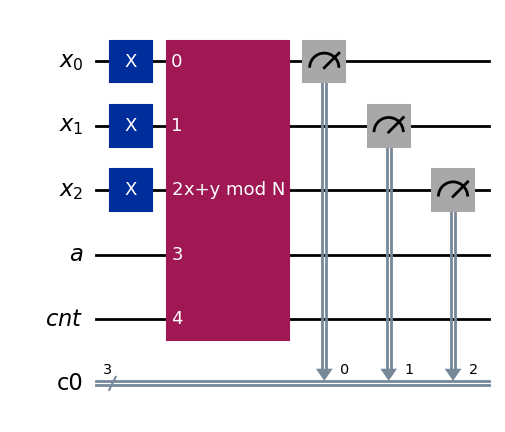

In [9]:
circuit = get_circuit(x_val,n_qubits)
circuit.append(addmodN(y_val,N=N_val,n_qubits=n_qubits),range(0,n_qubits+2))

circuit.measure(circuit.qregs[0][:],circuit.cregs[0][:n_qubits])
# circuit.measure(circuit.qregs[1][0],circuit.cregs[0][-1])
circuit.draw('mpl')


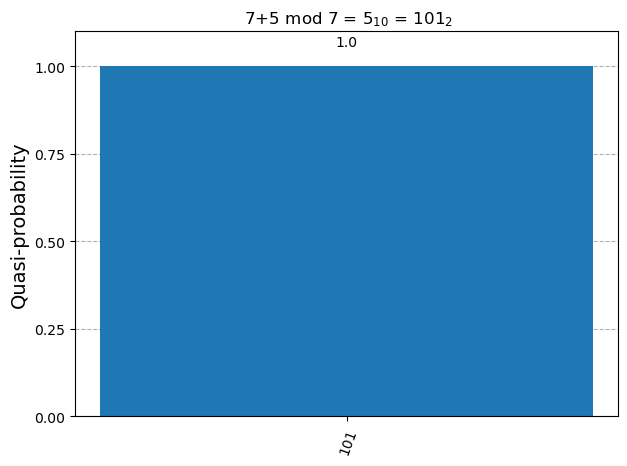

In [10]:
sim(circuit,AerSimulator(),100000,x_val,y_val,N_val,n_qubits)